Imports

In [ ]:
! pip install -r requirements.txt

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import yaml
import numpy as np
from mne.io import *
import matplotlib.pyplot as plt

from regressor import *
from preprocess import *

Configuration

In [6]:
with open("config/config.yml", "r") as file: config = yaml.safe_load(file)    
sfreq = config["hyperparameters"]["sfreq"]
tr = config["hyperparameters"]["tr"]

Paths

In [7]:
data_dir = os.path.join(config["paths"]["dataset_dir"], config["paths"]["subject_dir"])
eeg_outside_path = os.path.join(data_dir, config["paths"]["eeg_outside"])
eeg_inside_path = os.path.join(data_dir, config["paths"]["eeg_inside"])
spike_timing_path = os.path.join(data_dir, config["paths"]["spike_timinmg"])
os.makedirs('results', exist_ok=True)

Electrodes Postions

In [8]:
electrode_positions = config["electrode_positions_10-10"] # 'electrode_positions_10-20' to limit to 19 electrodes
electrode_labels = list(electrode_positions.keys())
electrode_positions_used = {label: electrode_positions[label] for label in electrode_labels}

EEG Data

In [ ]:
'''
Documentation: https://mne.tools/stable/generated/mne.io.read_raw.html

mne.io.read_raw_brainvision   For Brain Vision Recorder .eeg files
mne.io.read_raw_eeglab        For EEGLAB .set and optional .fdt files
mne.io.read_raw_edf           For .edf and .bdf formats
mne.io.read_raw_fif           For Native file format in Neuromag/Elekta/MEGIN systems
mne.io.read_raw_eegitab       For ITAB systems
mne.io.read_raw_nihon         For Nihon Kohden EEG files
mne.io.read_raw_gdf           For General-purpose physiological data format
mne.io.read_raw_cnt           For NeuroScan systems
mne.io.read_raw_egi           For older .egi files
mne.io.read_raw_mff           For .mff files used in EGI's later systems
mne.io.read_raw_nwb           For neuroscience open format data sharing
mne.io.read_raw_kit           For MEG data from KIT/Yokogawa systems
mne.io.read_raw_ctf           For Data from CTF systems
mne.io.read_raw_artemis123    For Data from Artemis123 system
mne.io.read_raw_eximia        For Near-Infrared Spectroscopy data
mne.io.read_raw_persyst       For Persyst EEG files
mne.io.read_raw_nicolet       For EEG data from Nicolet systems
mne.io.read_raw_fieldtrip     For real-time data using FieldTrip

'''

In [9]:
eeg_outside = read_raw_eeglab(eeg_outside_path, preload=True)
eeg_outside.pick_channels(electrode_labels)
eeg_outside_data = eeg_outside.get_data()
n_channels, n_samples = eeg_outside_data.shape
print(eeg_outside.info)
# eeg_outside.plot(scalings='auto', title="Raw EEG")

Reading D:\Academic\Datasets\sample_data\sub01\preprocessed\outside_preprocessed.fdt
Reading 0 ... 107869  =      0.000 ...   431.476 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T7, T8, P7, ...
 chs: 63 EEG
 custom_ref_applied: False
 dig: 66 items (3 Cardinal, 63 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 63
 projs: []
 sfreq: 250.0 Hz
>


In [10]:
eeg_inside = read_raw_eeglab(eeg_inside_path, preload=True)
eeg_inside.pick_channels(electrode_labels)
eeg_inside_data = eeg_inside.get_data()
n_channels, n_samples = eeg_inside_data.shape
print(eeg_inside.info)
# eeg_outside.plot(scalings='auto', title="Raw EEG")

Reading D:\Academic\Datasets\sample_data\sub01\preprocessed\inside_fMRIb_BCG_ICA.fdt
Reading 0 ... 67500  =      0.000 ...   270.000 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T7, T8, P7, ...
 chs: 63 EEG
 custom_ref_applied: False
 dig: 66 items (3 Cardinal, 63 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 63
 projs: []
 sfreq: 250.0 Hz
>


Outside Scanner IEDs timing

In [11]:
spike_timing = (np.loadtxt(spike_timing_path, dtype=float) * sfreq).astype('int')

Preprocess EEG (outside scanner)

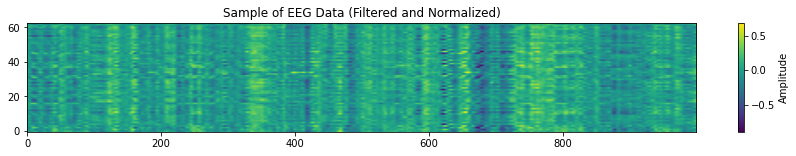

In [51]:
eeg_outside_filtered = preprocess_eeg(eeg_outside_data, sfreq=250)

plt.figure(figsize=(15, 2))
plt.title("Sample of EEG Data (Filtered and Normalized)")
plt.imshow(eeg_outside_filtered[:,:1000], aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Amplitude')
plt.savefig("results/eeg_outside.png", dpi=300, bbox_inches='tight')
plt.show()

Preprocess EEG (inside scanner)

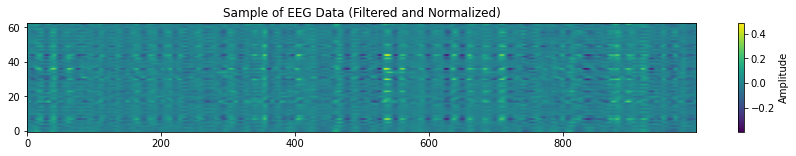

In [47]:
eeg_inside_filtered = preprocess_eeg(eeg_inside_data, sfreq=250)

plt.figure(figsize=(15, 2))
plt.title("Sample of EEG Data (Filtered and Normalized)")
plt.imshow(eeg_inside_filtered[:,:1000], aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Amplitude')
plt.savefig("results/eeg_inside.png", dpi=300, bbox_inches='tight')
plt.show()

Activity Map with Topography

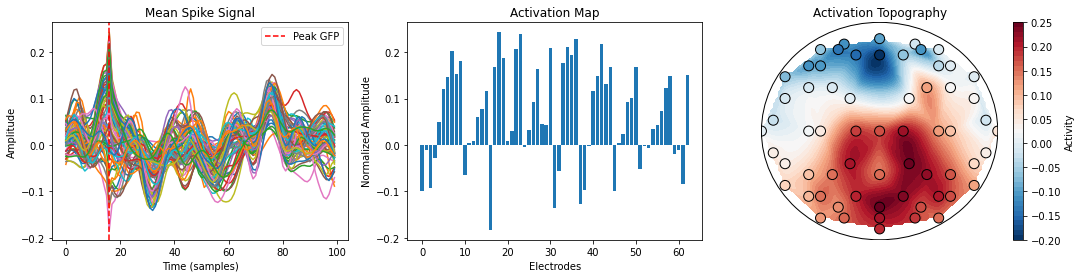

In [34]:
epileptic_map, mean_spike, gfp, peak_idx = activity_map(eeg_outside_filtered, spike_timing)

plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.title("Mean Spike Signal")
plt.plot(mean_spike.T)
plt.axvline(x=peak_idx, color='r', linestyle='--', label='Peak GFP')
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.legend()

plt.subplot(1, 3, 2)
plt.title("Activation Map")
plt.bar(range(len(epileptic_map)), epileptic_map)
plt.xlabel("Electrodes")
plt.ylabel("Normalized Amplitude")

plt.subplot(1, 3, 3)
epileptic_topography = generate_topography(epileptic_map, electrode_positions_used)

plt.savefig(f"results/spike_map_{n_channels}ch.png", dpi=300, bbox_inches='tight')
plt.show()

Spatial Correlation

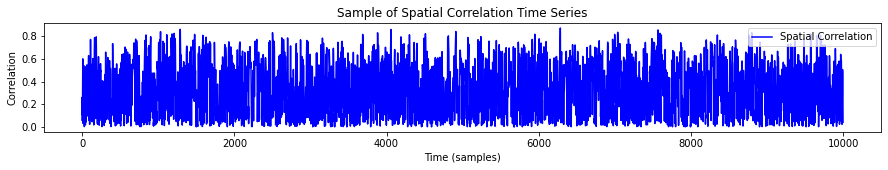

In [43]:
correlation_series = spatial_corr_with_topography(eeg_inside_filtered, epileptic_topography, electrode_positions_used)
np.savetxt("results/correlation_series.txt", correlation_series, fmt="%.6f", newline="\n")

plt.figure(figsize=(15, 2))
plt.title("Sample of Spatial Correlation Time Series")
plt.plot(correlation_series[:10000], label='Spatial Correlation', color='b')
plt.xlabel("Time (samples)")
plt.ylabel("Correlation")
plt.legend()
plt.savefig("results/correlation_series.png", dpi=300, bbox_inches='tight')
plt.show()

Convolution with HRF

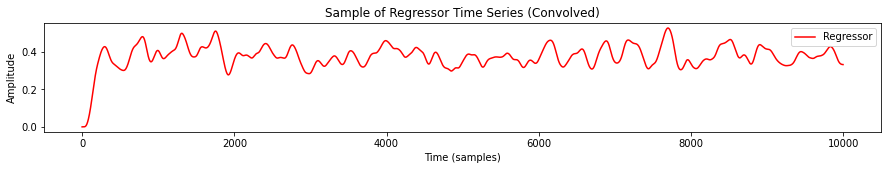

In [42]:
regressor = conv_hrf(correlation_series, tr)
np.savetxt("results/regressor.txt", correlation_series, fmt="%.6f", newline="\n")

plt.figure(figsize=(15, 2))
plt.title("Sample of Regressor Time Series (Convolved)")
plt.plot(regressor[:10000], label='Regressor', color='r')
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.legend()
plt.savefig("results/regressor.png", dpi=300, bbox_inches='tight')
plt.show()